<a href="https://colab.research.google.com/github/XuguangAi/BMI733/blob/main/AskReddit%20BERT%20V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install -q -U tensorflow-text

In [38]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [39]:
import pandas as pd

df = pd.read_csv("Reddit_balanced.csv")
df.head(5)

,Unnamed: 0,date,title,score,over_18,popularity
0,0,2021-09-23 00:52:22+00:00,"Americans that defend the confederate flag, why?",185,True,popular
1,1,2021-09-22 22:16:54+00:00,If God gave you the power to erase one thing f...,379,False,popular
2,2,2021-08-21 20:57:49+00:00,"Porn addicts,how did you end up being addicted...",119,True,popular
3,3,2021-08-21 20:53:42+00:00,"At your funeral, you can yell out one thing be...",101,False,popular
4,4,2021-08-21 18:52:58+00:00,"Without telling your age, how old are you?",240,False,popular


In [40]:
df['popularity'].value_counts()

unpopular    9999
popular      9998
Name: popularity, dtype: int64

In [41]:
df['popular']=df['popularity'].apply(lambda x: 1 if x=='popular' else 0)
df.head(5)

,Unnamed: 0,date,title,score,over_18,popularity,popular
0,0,2021-09-23 00:52:22+00:00,"Americans that defend the confederate flag, why?",185,True,popular,1
1,1,2021-09-22 22:16:54+00:00,If God gave you the power to erase one thing f...,379,False,popular,1
2,2,2021-08-21 20:57:49+00:00,"Porn addicts,how did you end up being addicted...",119,True,popular,1
3,3,2021-08-21 20:53:42+00:00,"At your funeral, you can yell out one thing be...",101,False,popular,1
4,4,2021-08-21 18:52:58+00:00,"Without telling your age, how old are you?",240,False,popular,1


In [42]:
import numpy as np

In [43]:
print('Average word length of questions in dataset is {0:.0f}.'.format(np.mean(df['title'].apply(lambda x: len(x.split())))))
print('Max word length of questions in dataset is {0:.0f}.'.format(np.max(df['title'].apply(lambda x: len(x.split())))))

Average word length of questions in dataset is 14.
Max word length of questions in dataset is 66.


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['title'],df['popular'],test_size=0.2)

In [45]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [46]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [47]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [48]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [49]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703827]], dtype=float32)

In [50]:
cosine_similarity([e[3]],[e[4]])

array([[0.98720336]], dtype=float32)

In [51]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [52]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      {'sequence_output':  109482241   keras_layer_2[0][0]              
                                                                 keras_layer_2[0][1]              
                                                                 keras_layer_2[0][2]              
____________________________________________________________________________________________

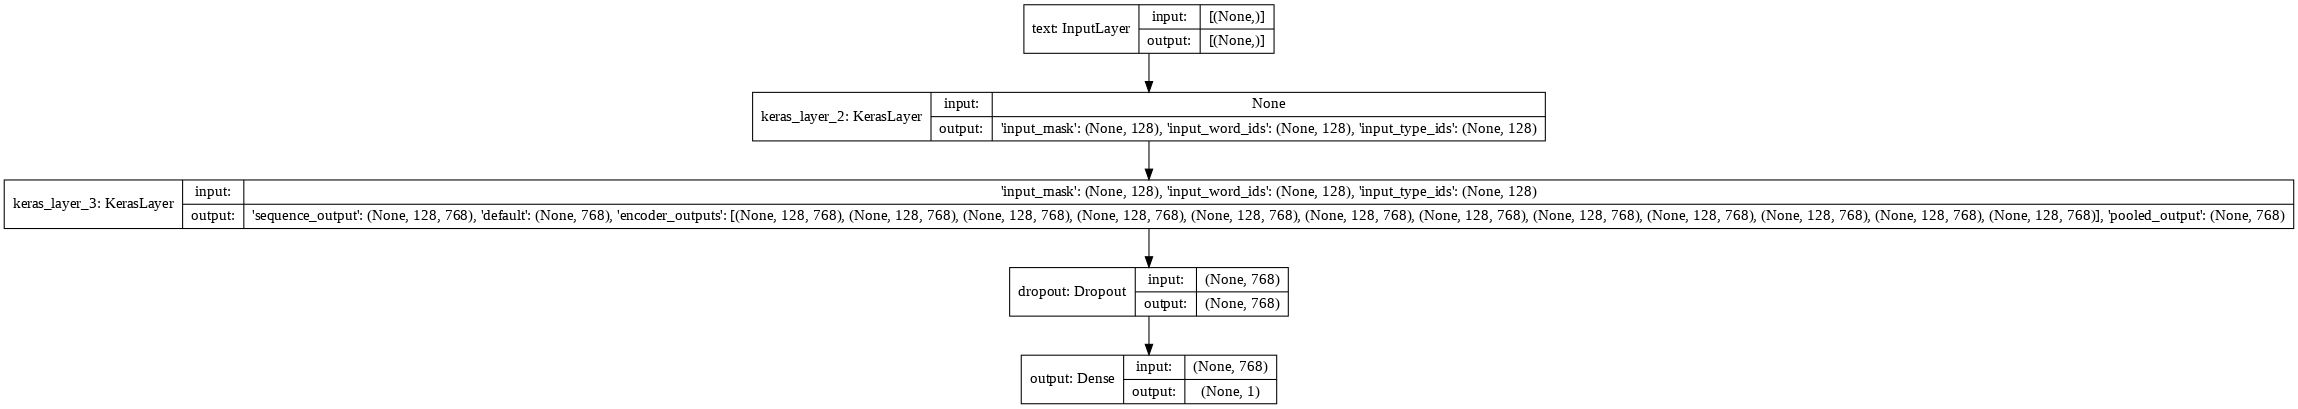

In [53]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [54]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.PrecisionAtRecall(0.5, name='F1')
]


model.compile('adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [55]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
500/500 [==============================] - 118s 215ms/step - loss: 0.7058 - accuracy: 0.5207 - precision: 0.5188 - recall: 0.5085 - F1: 0.5181
Epoch 2/10
500/500 [==============================] - 107s 214ms/step - loss: 0.6875 - accuracy: 0.5505 - precision: 0.5484 - recall: 0.5481 - F1: 0.5500
Epoch 3/10
500/500 [==============================] - 106s 212ms/step - loss: 0.6764 - accuracy: 0.5697 - precision: 0.5677 - recall: 0.5675 - F1: 0.5733
Epoch 4/10
500/500 [==============================] - 106s 212ms/step - loss: 0.6728 - accuracy: 0.5717 - precision: 0.5691 - recall: 0.5740 - F1: 0.5765
Epoch 5/10
500/500 [==============================] - 106s 212ms/step - loss: 0.6671 - accuracy: 0.5848 - precision: 0.5815 - recall: 0.5907 - F1: 0.5888
Epoch 6/10
500/500 [==============================] - 106s 212ms/step - loss: 0.6628 - accuracy: 0.5895 - precision: 0.5861 - recall: 0.5957 - F1: 0.6011
Epoch 7/10
500/500 [==============================] - 106s 213ms/step - loss

In [56]:
model.evaluate(X_test, y_test)

125/125 [==============================] - 28s 210ms/step - loss: 0.6416 - accuracy: 0.6308 - precision: 0.6076 - recall: 0.7772 - F1: 0.6467


[0.6416219472885132,
 0.6307500004768372,
 0.607594907283783,
 0.7772325873374939,
 0.6466876864433289]

In [57]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [58]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, ..., 0, 1, 1])

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(y_test, y_predicted)

array([[ 939, 1023],
       [ 454, 1584]])

In [60]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.67      0.48      0.56      1962
           1       0.61      0.78      0.68      2038

    accuracy                           0.63      4000
   macro avg       0.64      0.63      0.62      4000
weighted avg       0.64      0.63      0.62      4000



In [61]:
questions = [
    'You can choose one species to go extinct, what that would be?',
    'What are some tips and tricks for young adults living alone for the first time?',
]
model.predict(questions)

array([[0.39111048],
       [0.3887503 ]], dtype=float32)